# Classifying histograms of Cortical Thickness data

This notebook illustrates how to classify histograms of bounded values using the Fisher-Rao geometry of beta distributions. The values are measurements of cortical thickness for different patients, divided into 2 groups: healthy control subjects and Alzheimer's disease patients. This notebook uses the [information geometry module](https://github.com/geomstats/geomstats/tree/main/geomstats/information_geometry) of the open source Python package [geomstats](https://github.com/geomstats/geomstats).

In [ ]:
import geomstats.backend as gs

## Load and normalize cortical thickness data

Cortical Thickness (CTh) measured by structural Medical Resonance Imaging (MRI) is a biomarker for the early diagnosis of Alzheimer’s disease. The data used in this application were extracted from MR scans selected from the Alzheimer’s Disease Neuroimaging Initiative (ADNI) database. The population is composed of 143 subjects: 71 healthy controls subjects and 72 Alzheimer’s disease patients. CTh was measured using the Matlab toolbox CorThiZon (Querbes et al., 2009).

For each subject, the data consist in measurements of CTh along the whole cortical ribbon, with a normalized voxel size of 1mm along all directions. Due to the variability of the size and shape of the brain among the population of study, we obtain samples of unequal length. This results in the lack of a common representation space for the data.

To overcome this, a distribution approach is adopted: for each patient, a beta distribution is fitted to the measurements, after renormalization. The beta distributions are defined on the unit segment and present a rich variety of shapes, which makes them an interesting choice for this application. Each patient is represented by a point in the parameter space of beta distributions. In this representation space, KMeans clustering and KNN classification are then performed using both Euclidean and Fisher information distances.

In [1]:
import numpy as np
from time import time

import warnings
warnings.filterwarnings('ignore')

In [2]:
original_data = np.load('cortical_thickness.npy', allow_pickle=True)
labels = np.load('labels.npy', allow_pickle=True)

max_value = np.amax(np.vstack(original_data))
data = original_data / max_value

## Estimate beta parameters for each patient

In [3]:
import os
import subprocess

geomstats_gitroot_path = subprocess.check_output(
    ["git", "rev-parse", "--show-toplevel"], universal_newlines=True
)

os.chdir(geomstats_gitroot_path[:-1])

print("Working directory: ", os.getcwd())

Working directory:  /Users/Utilisateur/Python/geomstats


In [4]:
from geomstats.information_geometry.beta import BetaDistributions

beta = BetaDistributions()
points = []
for array in data:
    samples = gs.squeeze(array)
    beta_param = beta.maximum_likelihood_fit(samples)
    points.append(beta_param)
points = gs.stack(points)

INFO: Using numpy backend


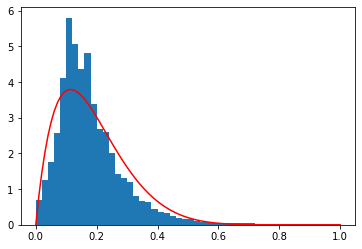

In [5]:
import matplotlib.pyplot as plt

index = 0
pdf = beta.point_to_pdf(points[index])
x = gs.linspace(0., 1., 100)

plt.hist(data[index], 50, density='True')
plt.plot(x, pdf(x), 'r')
plt.show()

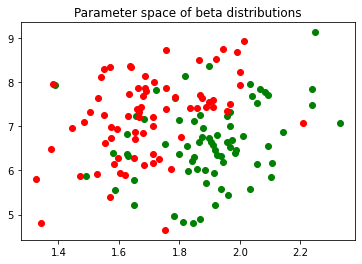

In [6]:
points_control = points[labels==False, :]
points_patients = points[labels==True, :]

plt.figure()
plt.plot(points_control[:, 0], points_control[:, 1], 'og')
plt.plot(points_patients[:, 0], points_patients[:, 1], 'or')
plt.title('Parameter space of beta distributions')
plt.show()

## KMeans clustering

In [7]:
from geomstats.geometry.euclidean import Euclidean
from geomstats.learning.kmeans import RiemannianKMeans

r2 = Euclidean(dim=2)
eucl_kmeans = RiemannianKMeans(space=r2, n_clusters=2)
eucl_kmeans.fit(points)

diff = gs.sum(gs.abs(eucl_kmeans.labels_ - labels)) / len(labels)

print(f'Euclidean KMeans clustering accuracy is {gs.maximum(diff, 1 - diff)}') 

Euclidean KMeans clustering accuracy is 0.6713286713286714


In [8]:
t0 = time()
riem_kmeans = RiemannianKMeans(space=beta, n_clusters=2, init='kmeans++', verbose=True)
riem_kmeans.fit(points)

diff = gs.sum(gs.abs(riem_kmeans.labels_ - labels)) / len(labels)

print('Riemannian KMeans clustering completed in ',
      np.around((time() - t0)/60, 1),
      ' min with accuracy ',
      gs.maximum(diff, 1 - diff)
) 

INFO: Initializing...
INFO: Iteration 0...
INFO: Convergence criterion at the end of iteration 0 is 0.12433831214674193.
INFO: Iteration 1...
INFO: Convergence criterion at the end of iteration 1 is 0.0170346827860902.
INFO: Iteration 2...
INFO: Convergence criterion at the end of iteration 2 is 0.009808337772866401.
INFO: Convergence reached after 2 iterations.


Riemannian KMeans clustering completed in  5.2  min with accuracy  0.7832167832167832


## KNN classification

In [9]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(points, labels, test_size=0.33, random_state=0)

print(f'Size of whole data set is {len(labels)}')
print(f'Size of train set is {len(y_train)}')
print(f'Size of test set is {len(y_test)}')

Size of whole data set is 143
Size of train set is 95
Size of test set is 48


Here we choose $K=10$ neighbors but several other values should be tested and cross-validation used to select the most appropriate value.

In [10]:
from geomstats.learning.knn import KNearestNeighborsClassifier

n_test = len(y_test)

enn = KNearestNeighborsClassifier(space=r2, n_neighbors=10)
rnn = KNearestNeighborsClassifier(space=beta, n_neighbors=10)

# Peform Euclidean KNN on processed data
enn.fit(X_train, y_train)
enn_pred = enn.predict(X_test)
enn_score = 1 - gs.sum(gs.abs(enn_pred*1 - y_test*1))/n_test
print(f'Euclidean KNN classification accuracy is {enn_score}.')

# Peform Riemannian KNN on processed data
t1 = time()
rnn.fit(X_train, y_train)
rnn_pred = rnn.predict(X_test)
rnn_score = 1 - gs.sum(gs.abs(rnn_pred*1 - y_test*1))/n_test
print('Riemannian KNN classification completed in ',
      np.around((time() - t1)/60, 1),
      ' min with accuracy ',
      rnn_score
)

Euclidean KNN classification accuracy is 0.6875.
Riemannian KNN classification completed in  11.6  min with accuracy  0.8125
